In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [24]:
from conformal_region_designer.case_studies.car_experiments import CarEnvironment, generate_calibration_dataset, generate_train_dataset, TrajectoryPredictor
from conformal_region_designer.utils import set_square_aspect_ratio

In [25]:
train_X, train_Y = generate_train_dataset(100)

In [26]:
predictor = TrajectoryPredictor(0.1)

Text(0.5, 0.98, 'Training Trajectories')

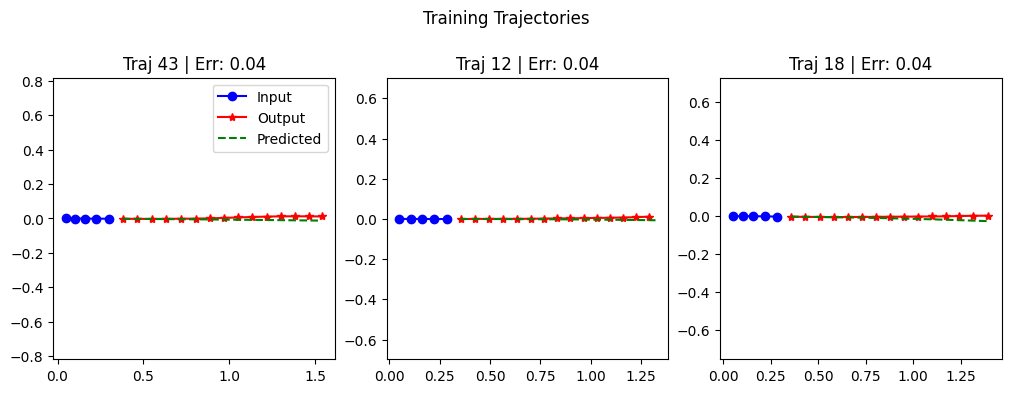

In [27]:
INDEX = np.random.choice(train_X.shape[0], 3)
fig, axs = plt.subplots(1, 3, figsize=(10, 4), dpi=100, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    ax.plot(train_X[INDEX[i], :, 0], train_X[INDEX[i], :, 1], 'bo-', label='Input')
    ax.plot(train_Y[INDEX[i], :, 0], train_Y[INDEX[i], :, 1], 'r*-', label='Output')
    prediction = predictor.predict_trajectory(train_X[INDEX[i]])
    error = np.linalg.norm(prediction - train_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--', label='Predicted')
    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
plt.suptitle('Training Trajectories')

In [28]:
cal_X, cal_Y = generate_calibration_dataset(10_000)

KeyboardInterrupt: 

Text(0.5, 0.98, 'Calibration Dataset')

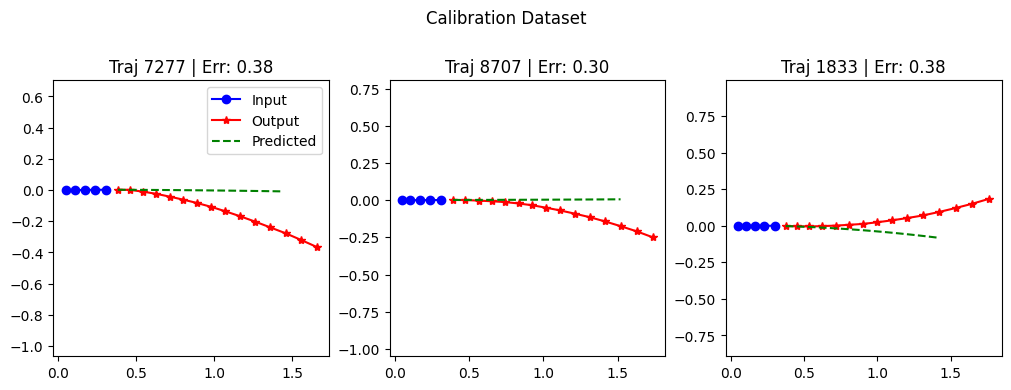

In [ ]:
INDEX = np.random.choice(cal_X.shape[0], 3)
fig, axs = plt.subplots(1, 3, figsize=(10, 4), dpi=100, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    ax.plot(cal_X[INDEX[i], :, 0], cal_X[INDEX[i], :, 1], 'bo-', label='Input')
    ax.plot(cal_Y[INDEX[i], :, 0], cal_Y[INDEX[i], :, 1], 'r*-', label='Output')
    prediction = predictor.predict_trajectory(cal_X[INDEX[i]])
    error = np.linalg.norm(prediction - cal_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--', label='Predicted')
    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
fig.suptitle('Calibration Dataset')

In [ ]:
cal_Y_hat = predictor.predict_batched_trajectories(cal_X)

In [ ]:
Z_eval = cal_Y_hat[:,-1,:2] - cal_Y[:,-1,:2]
np.random.shuffle(Z_eval)

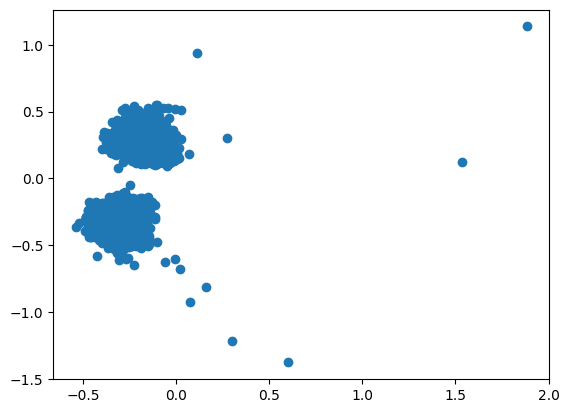

In [ ]:
plt.scatter(Z_eval[:,0], Z_eval[:,1])

# Use Parametrized Conformal Regions for Prediction

In [ ]:
from conformal_region_designer.density_estimation import KDE
from conformal_region_designer.clustering import MeanShiftClustering
from conformal_region_designer.shapes import HyperRectangle, ConvexHullTemplate, Ellipse
from conformal_region_designer.conformity_optimizer import ConformalRegion

In [ ]:
Z_cal_one = Z_eval[:Z_eval.shape[0]//3]
Z_cal_two = Z_eval[Z_eval.shape[0]//3:2*(Z_eval.shape[0]//3)]
Z_test = Z_eval[2*(Z_eval.shape[0]//3):]
print(Z_cal_one.shape, Z_cal_two.shape, Z_test.shape)

(3333, 2) (3333, 2) (3334, 2)


In [ ]:
DELTA = 0.90
de = KDE(grid_size=100)
cl = MeanShiftClustering()
pcr = ConformalRegion(de, cl, Ellipse, DELTA)

In [ ]:
Z_cal_one.shape

(3333, 2)

In [ ]:
pcr.fit(Z_cal_one)

Generating density points
Total Weight Sum: 0.7707442572742815
Fitting Clusters


KeyboardInterrupt: 

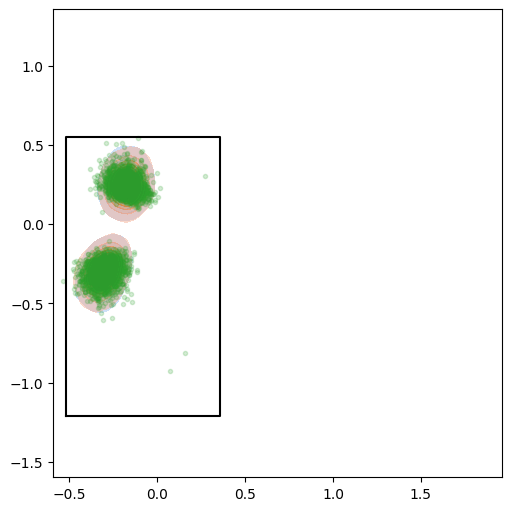

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100, constrained_layout=True)
sns.kdeplot(x=Z_cal_one[:,0], y=Z_cal_one[:, 1], fill=True, ax=ax, label='Calibration Set 1', alpha=0.5)
sns.kdeplot(x=Z_cal_two[:,0], y=Z_cal_two[:, 1], fill=True, ax=ax, label='Calibration Set 2', alpha=0.5)
plt.scatter(Z_test[:,0], Z_test[:,1], label='Test Set', alpha=0.2, marker='.')
# Plot the density estimator min and max
ax.plot(
    [de.min[0], de.min[0], de.max[0], de.max[0], de.min[0]],
    [de.min[1], de.max[1], de.max[1], de.min[1], de.min[1]],
    color="black",
)

In [ ]:
pcr.conformalize(Z_cal_two)

/Users/nandan/SourceCode/conformal_region_designer/conformal_region_designer/conformity_optimizer.py:46: RuntimeWarning: divide by zero encountered in divide
  scores[i] = shape.score_points(Z_cal)/self.normalizing_constant[i]


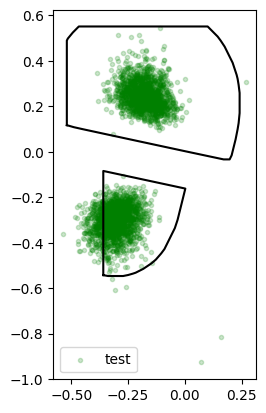

In [ ]:
fig, ax = plt.subplots()
#ax.scatter(Z_cal_one[:, 0], Z_cal_one[:, 1], color="red", marker=".", label="$D_{cal,1}$")
#ax.scatter(Z_cal_two[:, 0], Z_cal_two[:, 1], color="blue", marker=".", label="$D_{cal,2}$")
ax.scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="test", alpha=0.2)
ax.set_aspect("equal")
for shape_template in pcr.shapes:
    shape_template.plot(ax)
ax.legend()

## Show that coverage holds

In [ ]:
from sklearn.model_selection import ShuffleSplit
from tqdm.autonotebook import tqdm
rs = ShuffleSplit(n_splits=1000, test_size=0.5, random_state=42)
rs.get_n_splits(Z_eval)

/var/folders/p0/kgfq_z9j4d59b68jgyqqwv180000gn/T/ipykernel_5907/384868172.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


1000